# Week 13: Dimensionality Reduction

This notebook is based completely on Geron's one: https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb and his second edition book.

## Setup

In [1]:
# Common imports
import numpy as np

# To plot pretty figures
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. The curse of dimesionality

Many things behave very differently in high-dimensional space:
1. Most points in a high-dimensional hypercube are very close to the border.
2. The 'average' distance in a $10^6$-dimensional unit hypercube is about 408.25.

This means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations. In short, **the more dimensions the training set has, the greater the risk of overfitting it**.

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.

## 2. Main approaches for dimensionality reduction

### 2.1. Projection

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances actually lie within
(or close to) a much lower-dimensional subspace of the high-dimensional space.

#### A 3D dataset

In [2]:
def generate_3d_cloud():
    np.random.seed(4)
    m = 60
    w1, w2 = 0.1, 0.3
    noise = 0.1
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    X = np.empty((m, 3))
    X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
    return X
X = generate_3d_cloud()
X[:3]

array([[-1.01570027, -0.55091331, -0.26132626],
       [-0.00771675,  0.59958572,  0.03507755],
       [-0.95317135, -0.46453691, -0.24920288]])

#### PCA procedure

In [3]:
from sklearn.decomposition import PCA

In [4]:
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
X2D[:3]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729]])

The PCA object gives access to the principal components that it computed:

In [5]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Recover the 3D points projected on the plane (PCA 2D subspace).

In [6]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [7]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [8]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

#### Some plots to backup our findings

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [9]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [10]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

In [11]:
from mpl_toolkits.mplot3d import Axes3D

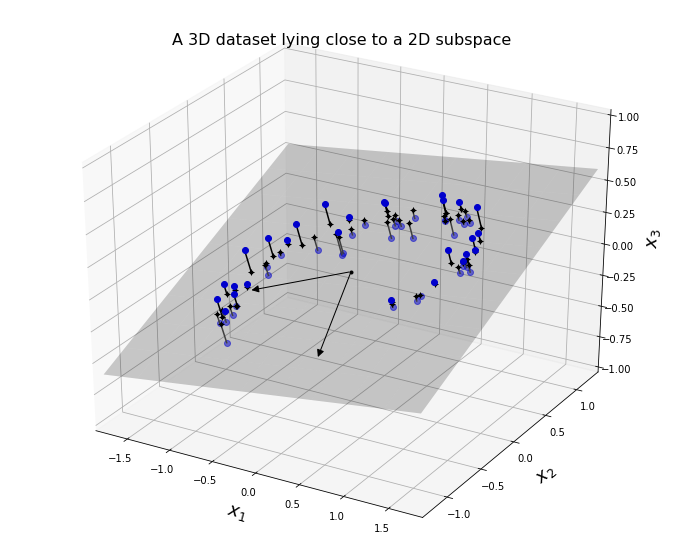

In [12]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0,C[0,0]],[0,C[0,1]],[0,C[0,2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0,C[1,0]],[0,C[1,1]],[0,C[1,2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

m = 60
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", 
        color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.title('A 3D dataset lying close to a 2D subspace', fontsize=16)
plt.show()

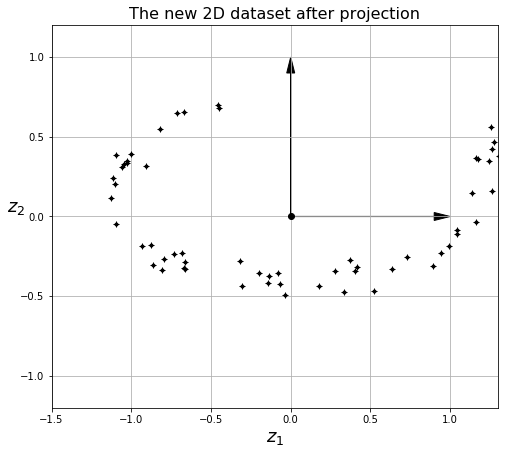

In [13]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
plt.title('The new 2D dataset after projection', fontsize=16)
ax.grid(True)

### 2.2. Manifold learning

However, projection is not always the best approach to dimensionality reduction. In many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset represented in the next figure.

In [14]:
from sklearn.datasets import make_swiss_roll

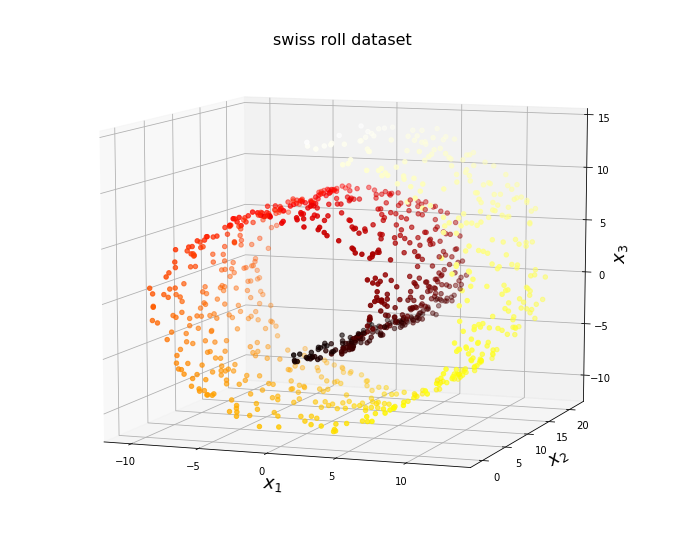

In [15]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.title("swiss roll dataset", fontsize=16)
plt.show()

Simply projecting onto a plane (e.g., by dropping $X_3$) would squash different layers of the Swiss roll together, as shown on the left of the figure bellow. However, what you really want is to unroll the Swiss roll to obtain the 2D dataset on the right of the next figure.

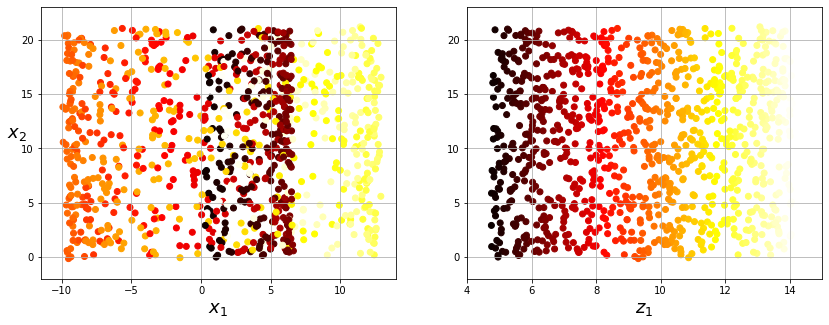

In [16]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a $d$-dimensional manifold is a part of an $n$-dimensional space (where $d < n$) that locally resembles a $d$-dimensional hyperplane.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called **Manifold Learning**. It relies on the **manifold assumption**, also called the **manifold hypothesis**, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. 

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold. For example, in the figure bellow the Swiss roll is split into two classes: in the 3D space, the decision boundary would be fairly complex.

In [17]:
from matplotlib import gridspec

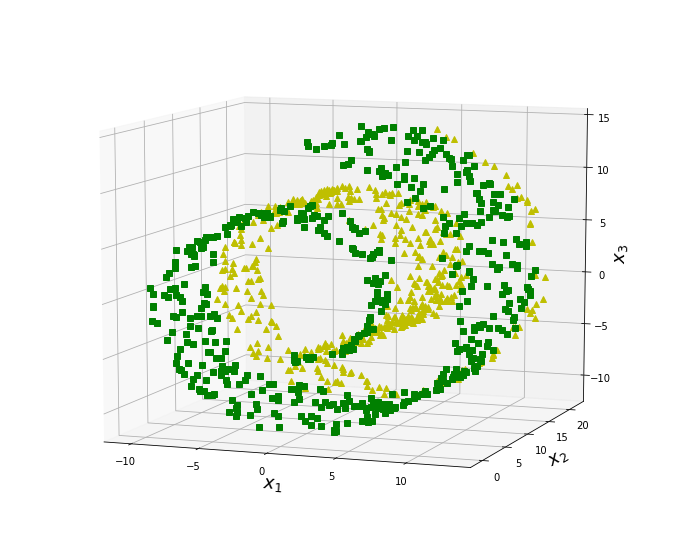

In [18]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

However, in the 2D unrolled manifold space, the decision boundary is a simple straight line.

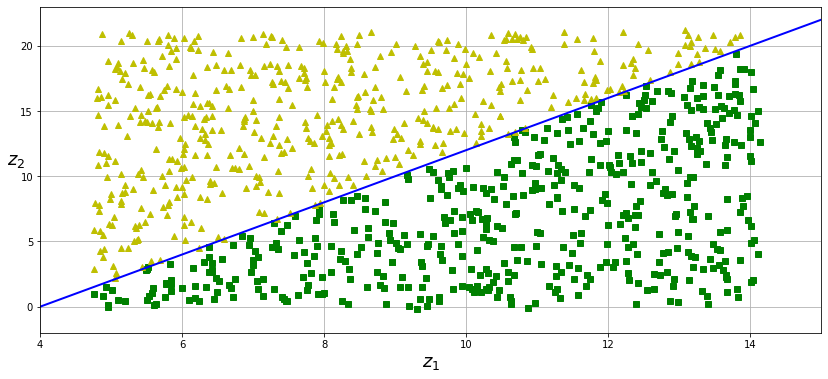

In [19]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

Nevertheless, this assumption does not always hold. For example, in the figure bellow, the decision boundary is located at $X_1=5$. This decision boundary looks very simple in the original 3D space (a vertical plane.)

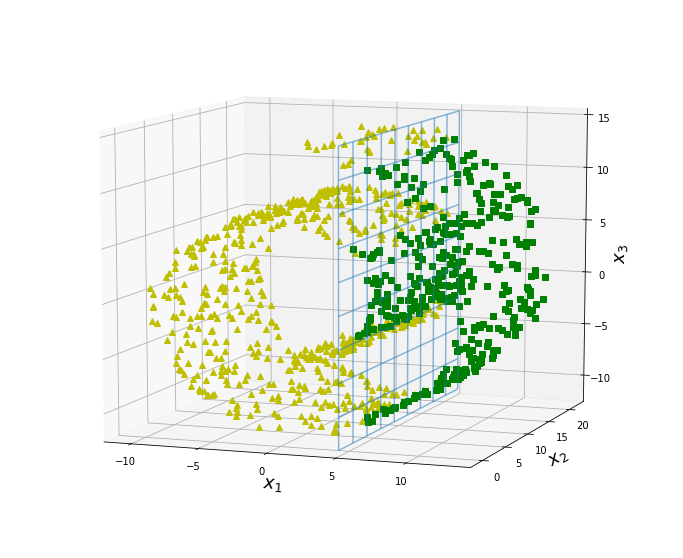

In [20]:
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111, projection='3d')
positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

But, it looks more complex in the unrolled manifold (a collection of four independent line segments).

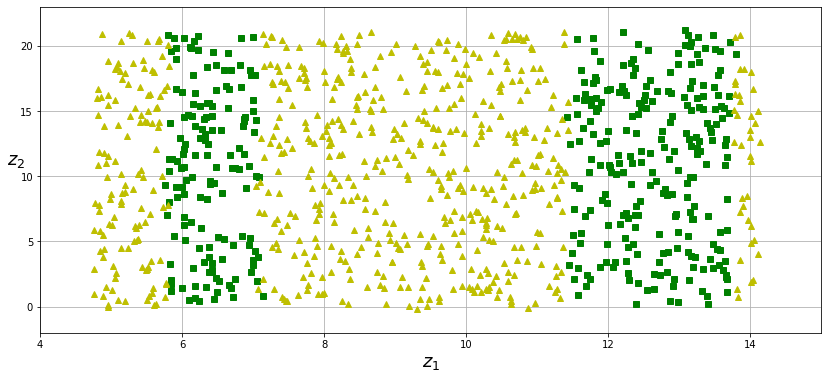

In [21]:
fig = plt.figure(figsize=(14,6))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In short, if you reduce the dimensionality of your training set before training a model, it will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

## 3. PCA

Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

### 3.1. Preserving the variance

Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. For example, a simple 2D dataset is represented on the left of the figure bellow, along with three different axes (i.e., one-dimensional hyperplanes). On the right is the result of the projection of the dataset onto each of these axes. As you can see, the projection onto the solid line preserves the maximum variance, while the projection onto the dotted line preserves very little variance, and the projection onto the dashed line preserves an intermediate amount of variance.

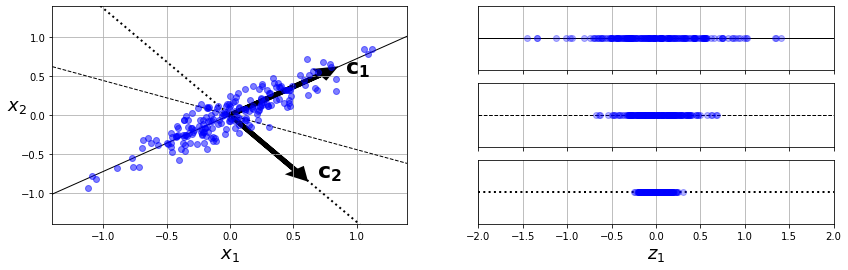

In [22]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(14,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

### 3.2. Principal components

PCA identifies the axis that accounts for the largest amount of variance in the training set. In the figure above, it is the solid line. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. In this 2D example there is no choice: it is the dotted line. If it were a higher-dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on--as many axes as the number of dimensions in the dataset.

The unit vector that defines the $i$-th axis is called the $i$-th principal component (PC). In
the previous figure, the $1$-th PC is $c_1$ and the $2$-nd PC is $c_2$. In the first figure the first two PCs are represented by the orthogonal arrows in the plane, and the third PC would be orthogonal to the plane (pointing up or down).

#### PCA using SVD decomposition

Singular Value Decomposition (SVD) is a standard matrix factorization technique that can decompose the training set matrix $X$ into the matrix multiplication of three matrices 

$$U\Sigma V^T,$$ 

where $V$ contains all the principal components that we are looking for, as shown in the equation bellow. 

$$ V =  
 \begin{pmatrix}
  c_1 & c_2 & \cdots & c_n 
 \end{pmatrix}. $$
 
The following Python code uses NumPy’s `svd()` function to obtain all the principal components of the training set, then extracts the first two PCs:

In [23]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

np.allclose(X_centered, U.dot(S).dot(Vt))

True

### 3.3. Projecting down d dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible. For example, in the first figure the 3D dataset is projected down to the 2D plane defined by the first two principal components, preserving a large part of the dataset's variance. As a result, the 2D projection looks very much like the original 3D dataset.

To project the training set onto the hyperplane, you can simply compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ principal components (i.e., the matrix composed of the first $d$ columns of V), as shown in equation bellow. $$ X_{d\mbox{-proj}} = XW_d. $$

The following Python code projects the training set onto the plane defined by the first two principal components:

In [24]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D
X2D_using_svd[:3]

array([[-0.89608814,  0.02615763],
       [-0.04536034, -0.18594886],
       [ 0.13835917, -0.03116662]])

### 3.4. Using scikit-learn

Scikit-Learn's PCA class implements PCA using SVD decomposition just like we did before. The following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note that it automatically takes care of centering the data):

In [25]:
X = generate_3d_cloud()
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, you can access the principal components using the `components_` variable (note that it contains the PCs as horizontal vectors, so, for example, the first principal component is equal to

In [26]:
pca.components_.T[:,0]

array([-0.93636116, -0.29854881, -0.18465208])

### 3.5. Explained variance ratio

Another very useful piece of information is the *explained variance ratio* of each principal component, available via the `explained_variance_ratio_` variable. It indicates the proportion of the dataset's variance that lies along the axis of each principal component. For example, let's look at the explained variance ratios of the first two components of the 3D dataset represented in the first figure:

In [27]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

This tells you that 84.2% of the dataset's variance lies along the first axis, and 14.6% lies along the second axis. This leaves less than 1.2% for the third axis, so it is reasonable to assume that it probably carries little information.

### 3.6. Choosing the right number of dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%). Unless, of course, you are reducing dimensionality for data visualization--in that case you will generally want to reduce the
dimensionality down to 2 or 3.

#### MNIST compression

It is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

In [28]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [29]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [30]:
y.shape

(70000,)

Each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0(white) to 255 (black). Let's take a peek at one digit from the dataset. All you need to
do is grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's `imshow()` function:

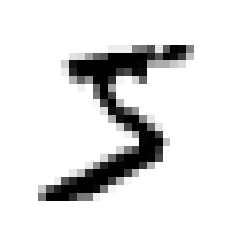

In [31]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [32]:
y[0]

'5'

Each image is labeled with the digit it represents, and this label is a string. However, we prefer numbers, so let's cast `y` to integers:

In [33]:
y = y.astype(np.uint8)

Now let us split our data set:

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

The following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance:

In [35]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

You could then set `n_components=d` and run PCA again. However, there is a much better option: instead of specifying the number of principal components you want to preserve, you can set `n_components` to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [36]:
pca = PCA(n_components=0.95)
X_reduced_pca = pca.fit_transform(X_train)
pca.n_components_

154

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot `cumsum`; see figure bellow.) There will usually be an elbow in the curve, where the explained variance stops growing fast. You can think of this as the intrinsic dimensionality of the dataset. In this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn't lose too much explained variance.

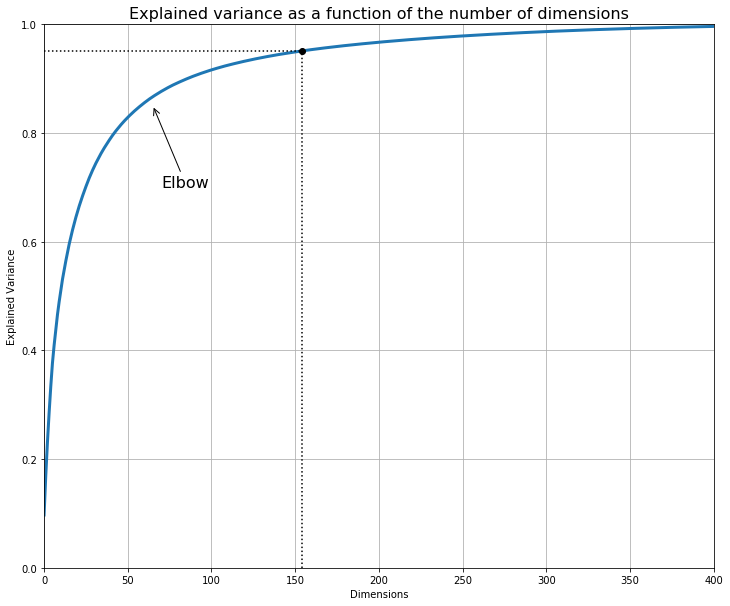

In [38]:
plt.figure(figsize=(12,10))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.title("Explained variance as a function of the number of dimensions", fontsize=16)
plt.show()

### 3.7. PCA for compresion

Obviously after dimensionality reduction, the training set takes up much less space. For example, try applying PCA to the MNIST dataset while preserving 95% of its variance. You should find that each instance will have just over 150 features, instead of the original 784 features. So while most of the variance is preserved, the dataset is
now less than 20% of its original size! This is a reasonable compression ratio, and you can see how this can speed up a classification algorithm (such as an SVM classifier) tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. Of course this won't give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be quite close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error. 

For example, the following code compresses the MNIST dataset down to 154 dimensions, then uses the `inverse_transform()` method to decompress it back to 784 dimensions. the figure bellow shows a few digits from the original training set (on the left), and the corresponding digits after compression and decompression. You can see that there is a slight image quality loss, but the digits are still mostly intact.

In [39]:
X_recovered = pca.inverse_transform(X_reduced_pca)
X_recovered[0].shape

(784,)

Text(0.5, 1.0, 'Compressed')

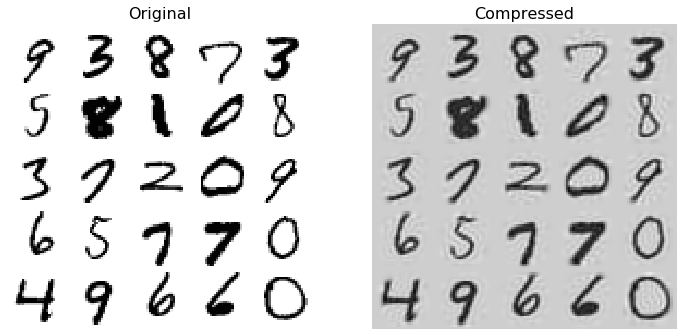

In [40]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(12,10))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

The equation of the inverse transformation is shown in given by 

$$ X_{\mbox{recovered}} = X_{d-\mbox{proj}}{W_d}^T. $$

### 3.8. Randomized PCA

If you set the `svd_solver` hyperparameter to `"randomized"`, Scikit-Learn uses a stochastic algorithm called *Randomized PCA* that quickly finds an approximation of the first $d$ principal components. Its computational complexity is $O(m\times d^2) + O(d^3)$, instead of $O(m\times n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when $d$ is much smaller than $n$:

In [41]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

By default, `svd_solver` is actually set to `"auto"`: Scikit-Learn automatically uses the randomized PCA algorithm if $m$ or $n$ is greater than 500 and $d$ is less than 80% of $m$ or $n$, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the `svd_solver` hyperparameter to `"full"`.

### 3.9. Incremental PCA

One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, *Incremental PCA* (IPCA) algorithms have been developed: you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new instances arrive).

The following code splits the MNIST dataset into 100 mini-batches (using NumPy's `array_split()` function) and feeds them to Scikit-Learn's `IncrementalPCA` class to reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like before.) Note that you must call the `partial_fit()` method with each mini-batch rather than the fit() method with the whole training set:

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)
X_reduced_inc_pca = inc_pca.transform(X_train)

....................................................................................................

Alternatively, you can use NumPy's `memmap` class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. Since the `IncrementalPCA` class uses only a small part of the array at any given time, the memory usage remains
under control. This makes it possible to call the usual `fit()` method, as you can see in the following code:

Text(0.5, 1.0, 'Compressed')

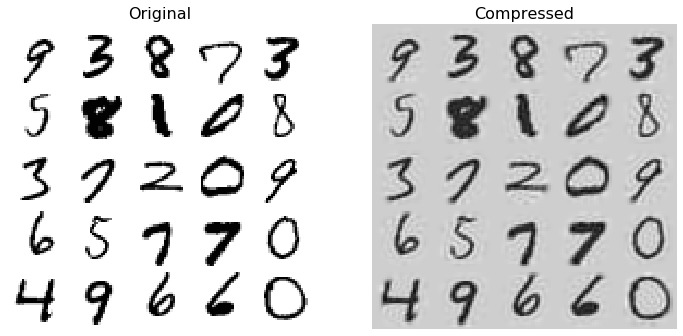

In [43]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced_inc_pca)

plt.figure(figsize=(12,10))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Compressed", fontsize=16)

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal:

In [44]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [45]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

#### Using `memmap()`

Alternatively, you can use NumPy's `memmap` class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. Since the `IncrementalPCA` class uses only a small part of the array at any given time, the memory usage remains
under control. 

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [46]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [47]:
del X_mm

Next, another program would load the data and use it for training:

In [48]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

#### Time complexity

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [49]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca, name in zip([regular_pca, inc_pca, rnd_pca], ['PCA','Incremental PCA','Randomized PCA']):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 0.9 seconds
    Incremental PCA: 6.2 seconds
    Randomized PCA: 0.8 seconds
n_components = 10
    PCA: 1.0 seconds
    Incremental PCA: 6.4 seconds
    Randomized PCA: 0.9 seconds
n_components = 154
    PCA: 2.6 seconds
    Incremental PCA: 8.7 seconds
    Randomized PCA: 2.6 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity')

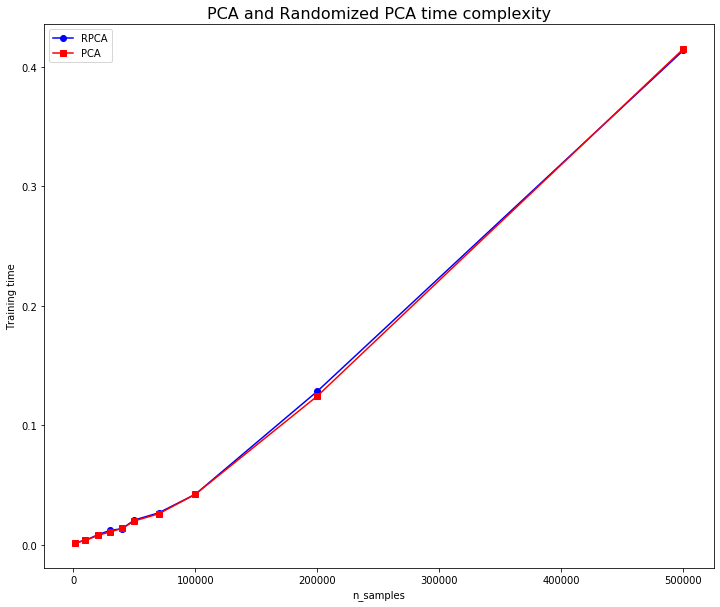

In [50]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(12,10))    
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity", fontsize=16)

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity')

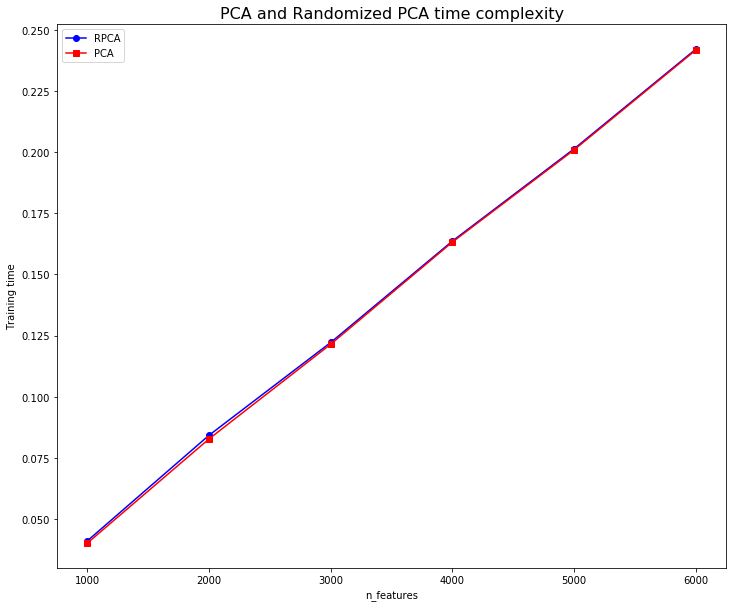

In [51]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.figure(figsize=(12,10))
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity", fontsize=16)

## 4. Kernel PCA

The kernel trick is a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called *Kernel PCA* **(kPCA)**. It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

For example, the following code uses Scikit-Learn's `KernelPCA` class to perform kPCA with an RBF kernel:

In [52]:
from sklearn.decomposition import KernelPCA

In [53]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

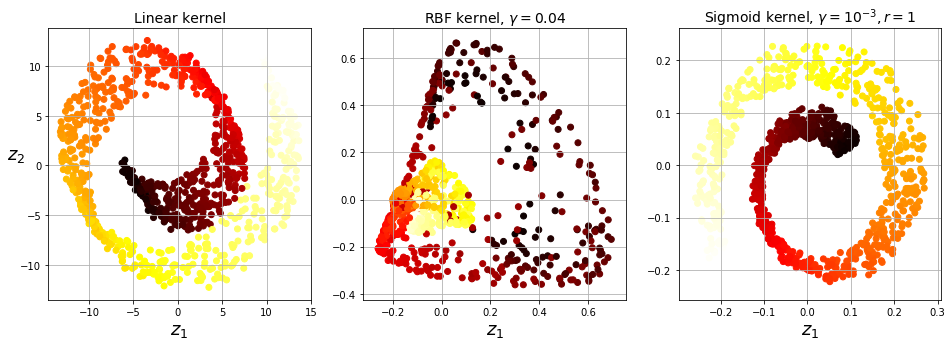

In [54]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(16, 5))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

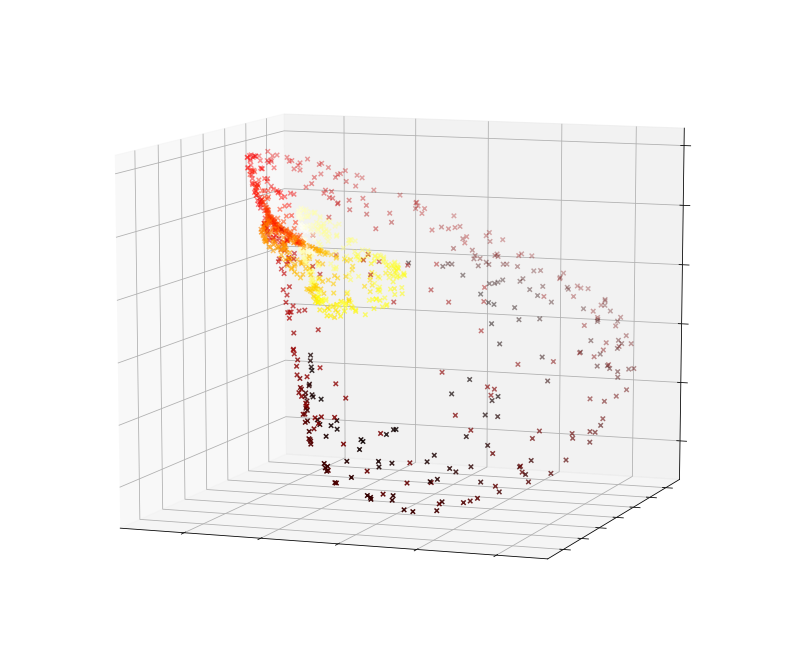

In [55]:
plt.figure(figsize=(14,12))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.show()

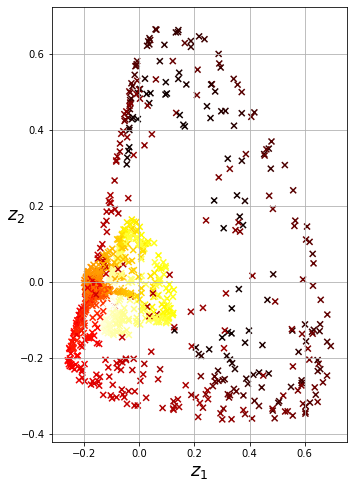

In [56]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(18,8))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

#### Selecting a Kernel and Tuning Hyperparameters

As kPCA is an unsupervised learning algorithm, there is no obvious performance measure to help you select the best kernel and hyperparameter values. However, dimensionality reduction is often a preparation step for a supervised learning task (e.g., classification), so you can simply use grid search to select the kernel and hyperparameters that lead to the best performance on that task. 

For example, the following code creates a two-step pipeline, first reducing dimensionality to two dimensions
using kPCA, then applying Logistic Regression for classification. Then it uses `GridSearchCV` to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline:

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

The best kernel and hyperparameters are then available through the `best_params_` variable:

In [58]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another approach, this time entirely unsupervised, is to select the kernel and hyperparameters that yield the lowest reconstruction error. However, reconstruction is not as easy as with linear PCA. Here's why. Figure 8-11 shows the original Swiss roll 3D dataset (top left), and the resulting 2D dataset after kPCA is applied using an RBF kernel (top right). Thanks to the kernel trick, this is mathematically equivalent to mapping the training set to an infinite-dimensional feature space (bottom right) using the *feature map* $\varphi$, then projecting the transformed training set down to 2D using linear PCA. <img src="kPCA.png">

Notice that if we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, not in the original space (e.g., like the one represented by an $x$ in the diagram). Since the feature space is infinite-dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error. Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point. This is called the reconstruction pre-image. Once you have this *pre-image*, you can measure its squared distance to the original instance. You can then select the kernel and hyperparameters that minimize this reconstruction pre-image error.

You may be wondering how to perform this reconstruction. One solution is to train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit-Learn will do this automatically if you set `fit_inverse_transform=True`, as shown in the following code:

In [59]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

You can then compute the reconstruction pre-image error:

In [60]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

Now you can use grid search with cross-validation to find the kernel and hyperparameters that minimize this pre-image reconstruction error.

## 5. LLE

*Locally Linear Embedding* (**LLE**) is another very powerful *nonlinear dimensionality reduction* (**NLDR**) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors (c.n.), and then looking for a low-dimensional representation of the training set where these local relationships are best preserved (more details shortly). This makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

For example, the following code uses Scikit-Learn's `LocallyLinearEmbedding` class to unroll the Swiss roll. The resulting 2D dataset is shown in Figure 8-12???. As you can see, the Swiss roll is completely unrolled and the distances between instances are locally well preserved. However, distances are not preserved on a larger scale: the left part of the unrolled Swiss roll is stretched, while the right part is squeezed. Nevertheless, LLE did a pretty good job at modeling the manifold.

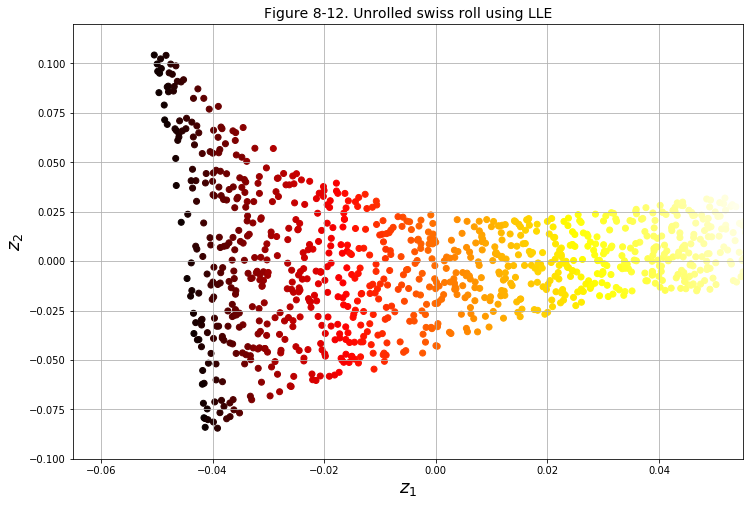

In [61]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

plt.figure(figsize=(12,8))
plt.title("Figure 8-12. Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

Here's how LLE works: first, for each training instance $x^(i)$, the algorithm identifies its $k$ closest neighbors (in the preceding code $k = 10$), then tries to reconstruct $x^(i)$ as a linear function of these neighbors. More specifically, it finds the weights $w_{i,j}$ such that the squared distance between $x^(i)$ and $$ \sum_{j=1}^m w_{i,j}x^{(j)}$$ is as small as possible, assuming $w_{i,j}=0$ if $x^{(j)}$ is not one of the $k$ closest neighbors of $x^{(i)}$. Thus the first step of LLE is the constrained optimization problem described in Equation 8-4, where $W$ is the weight matrix containing all the weights $w_{i,j}$. The second constraint simply normalizes the weights for each training instance $x^{(i)}$. <img src="eq8-4.png">

After this step, the weight matrix $\widehat{W}$ (containing the weights $\hat{w}_{i,j}$) encodes the local
linear relationships between the training instances. Now the second step is to map the training instances into a $d$-dimensional space (where $d < n$) while preserving these local relationships as much as possible. If $z^{(i)}$ is the image of $x^{(i)}$ in this $d$-dimensional space, then we want the squared distance between $z^{(i)}$ and $$ \sum_{j=1}^m \hat{w}_{i,j}z^{(j)}$$ to be as small as possible. This idea leads to the unconstrained optimization problem described in Equation 8-5. It looks very similar to the first step, but instead of keeping the instances fixed and finding the optimal weights, we are doing the reverse: keeping the
weights fixed and finding the optimal position of the instances' images in the low-dimensional space. Note that $Z$ is the matrix containing all $z^{(i)}$. <img src="eq8-5.png">

Scikit-Learn's LLE implementation has the following computational complexity: $O(m\log(m)n\log(k))$ for finding the $k$ nearest neighbors, $O(mnk^3)$ for optimizing the weights, and $O(dm^2)$ for constructing the low-dimensional representations. Unfortunately, the $m^2$ in the last term makes this algorithm scale poorly to very large datasets.